In [1]:
import passing.network_graph as ng
import passing.sonar_graph as sg

match_id=3788766

# Passing Networks

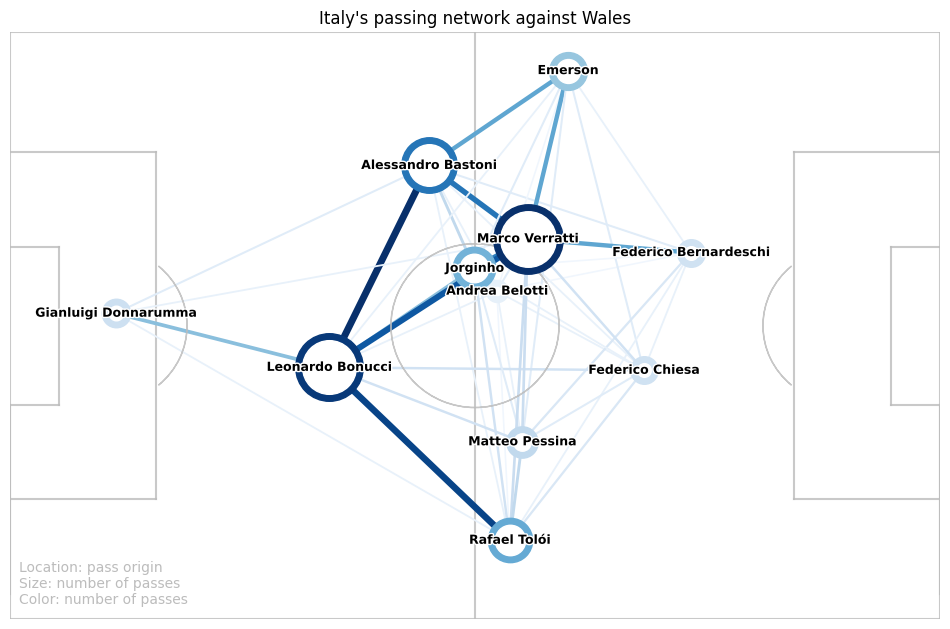

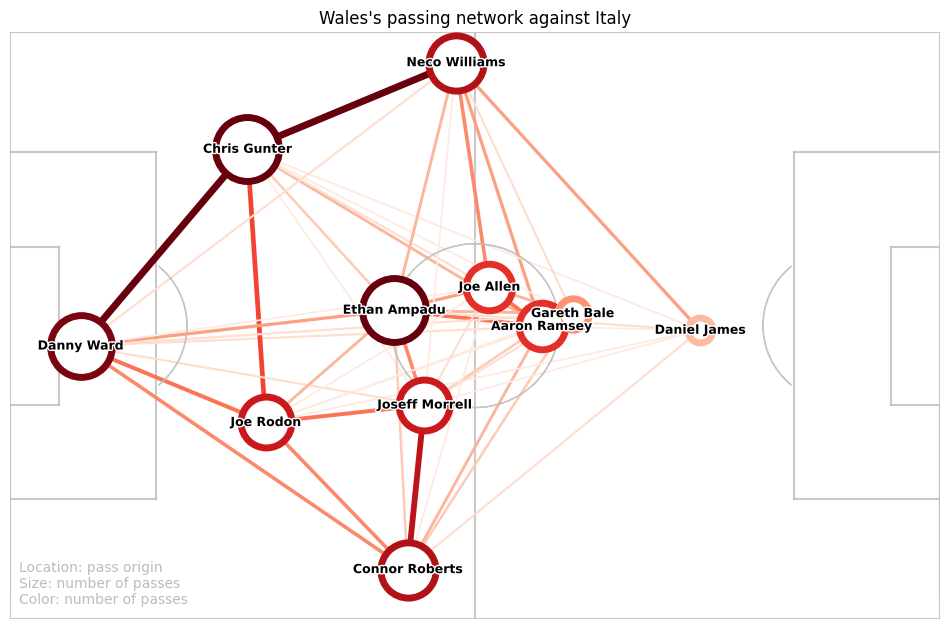

In [2]:
ng.plot_passing_networks(match_id)

# Team Sonars

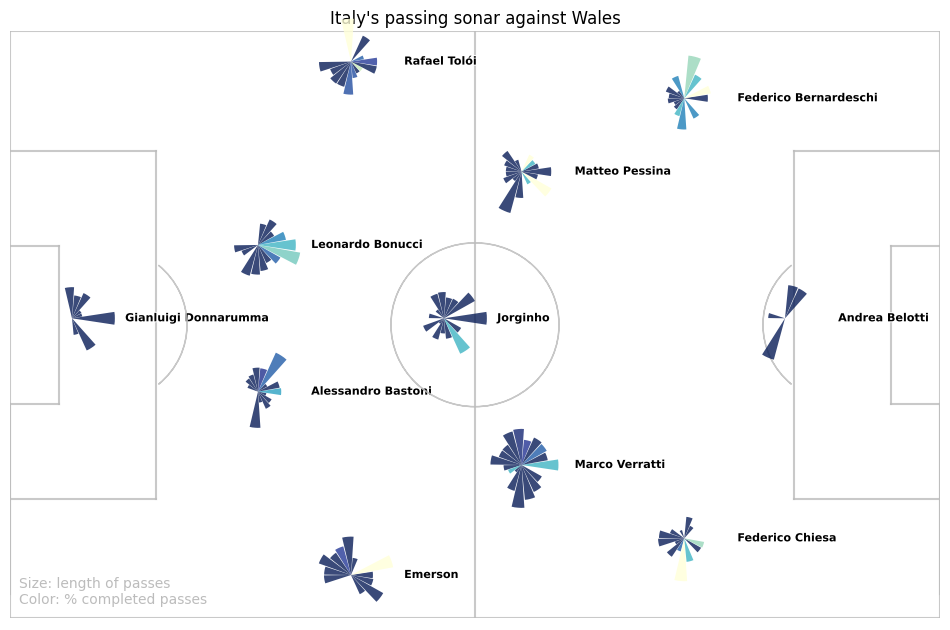

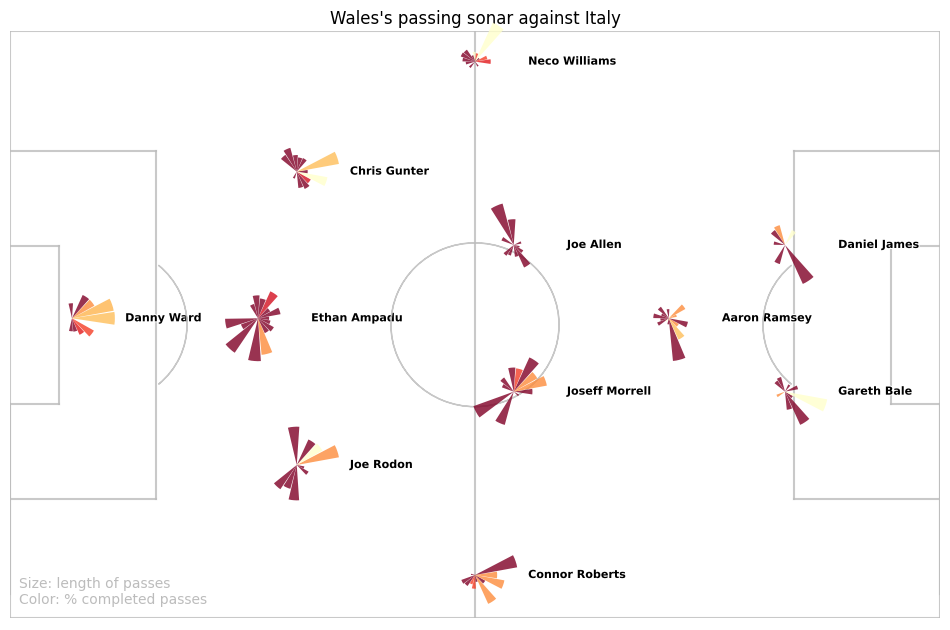

In [3]:
sg.plot_passing_sonars(match_id)